# Preface

This short notebook and accompanying scripts are intended to demonstrate:
- a proficiency in Python 
- my ability to write interpretable/sensible code
- a high-level approach to exploratory data analysis

I use [this free COVID-19 API](https://api.covid19api.com/) as my source of data. See `src.queries.py` for details.

# Installations

In [36]:
# Uncomment the following line and run cell to install dependencies in current kernel

# %pip install -r requirements.txt

_______

In [53]:
# Imports

from src import *
from utils import *

from statsmodels.tsa.api import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Markdown as md

In [38]:
# Define some global variables

COUNTRIES = ['Germany', 'Italy', 'Spain']
CASE_TYPES = ['Confirmed', 'Active', 'Deaths']

TRAIN_SIZE = 400
PRED_WINDOW = 50
THRESHOLD = 100 # number of cases below which I am not tracking (this is to avoid the noisy data in the early days of COVID-19 case-reporting)

# Basic EDA

In [39]:
# Load some data

df = get_data(country="Canada", preprocess=True)  # NOTE: I perform some data preprocessing within this loading step

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 885 entries, 2020-01-23 00:00:00+00:00 to 2022-06-25 00:00:00+00:00
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           885 non-null    object
 1   Country      885 non-null    object
 2   CountryCode  885 non-null    object
 3   Province     885 non-null    object
 4   City         885 non-null    object
 5   CityCode     885 non-null    object
 6   Lat          885 non-null    object
 7   Lon          885 non-null    object
 8   Confirmed    885 non-null    int64 
 9   Deaths       885 non-null    int64 
 10  Recovered    885 non-null    int64 
 11  Active       885 non-null    int64 
dtypes: int64(4), object(8)
memory usage: 89.9+ KB


In [41]:
# It looks like the more granular regional
# data is not supplied by free version of API

print(df.Province.value_counts())
print(df.City.value_counts())
print(df.CityCode.value_counts())

    885
Name: Province, dtype: int64
    885
Name: City, dtype: int64
    885
Name: CityCode, dtype: int64


In [42]:
df.describe()

,Confirmed,Deaths,Recovered,Active
count,8.850000e+02,885.000000,8.850000e+02,8.850000e+02
mean,1.087826e+06,19101.024859,2.985857e+05,8.036811e+05
std,1.044961e+06,10834.025235,4.576510e+05,1.158100e+06
min,2.000000e+00,0.000000,0.000000e+00,0.000000e+00
25%,1.156790e+05,9065.000000,0.000000e+00,0.000000e+00
50%,8.984510e+05,21977.000000,4.006900e+04,8.672000e+03
75%,1.429118e+06,26303.000000,4.506690e+05,1.402815e+06
max,3.352587e+06,37271.000000,1.405971e+06,3.315316e+06


I'll create some plots to get a sense for what the data looks like and whether or not there are any obvious trends that would be useful to know about before moving forward.

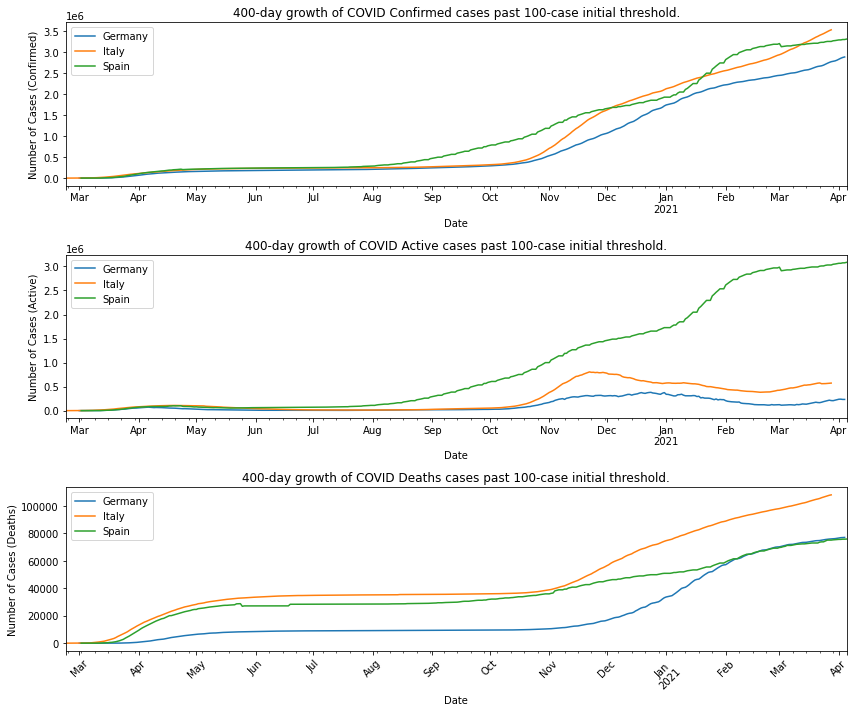

In [43]:
figure, _ = plot_initial_growth(
    COUNTRIES, 
    first_n_days=TRAIN_SIZE, 
    threshold=THRESHOLD, 
    case_types=CASE_TYPES,
    )

figure.figure.set_figheight(10)
figure.figure.set_figwidth(12)
figure.figure.tight_layout()

# Analysis of time-series data

In [44]:
# Let's look more closely at a single country's COVID cases
# and try to model based on 'type' of case

COUNTRY = "Spain"
CASE_TYPE = "Active"

active_cases = get_data(country=COUNTRY, threshold=THRESHOLD, first_n_days=TRAIN_SIZE + PRED_WINDOW)

train_data = active_cases.iloc[:TRAIN_SIZE][[CASE_TYPE]]
test_data = active_cases.iloc[-PRED_WINDOW:][[CASE_TYPE]]

# sanity check to make sure nothing is going wrong with splitting
assert len(active_cases) == len(train_data) + len(test_data)

train_data.freq, test_data.freq = pd.infer_freq(train_data), pd.infer_freq(test_data)

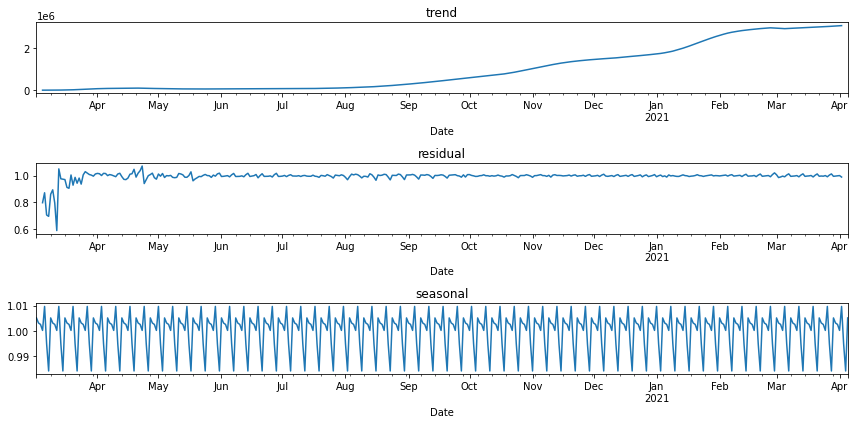

In [45]:
# Model selection/diagnostic

dcomp = seasonal_decompose(train_data, model="multiplicative")
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(12,6))

dcomp.trend.plot(ax=ax1)
dcomp.resid.plot(ax=ax2)
dcomp.seasonal.plot(ax=ax3)

ax1.set_title('trend');
ax2.set_title('residual');
ax3.set_title('seasonal');
fig.tight_layout()

Unremarkable seasonal, and residual components. Clearly not a stationary time-series, but will show this quantitatively using the Augmented Dickey-Fuller test.

In [46]:
DF_test = adfuller(train_data[CASE_TYPE])
DF_pvalue = DF_test[1]

print(f"Dickey-Fuller test for stationarity yield p-value of: {DF_pvalue}")

Dickey-Fuller test for stationarity yield p-value of: 0.9729080960479859


In [55]:
md(f"Suppose we use an alpha threshold of 5%, the p-value here ({round(DF_pvalue, 3)}) suggests we _cannot/fail to_ reject the null hypothesis of the Augmented Dickey-Fuller test; so before I go about fitting a time-series model to this, either I should begin by looking at methods to make the time series stationary, or use a model which 'supports' non-stationary time-series. I'll check out the ACF and PACF plots as well while I'm here...")

Suppose we use an alpha threshold of 5%, the p-value here (0.973) suggests we _cannot/fail to_ reject the null hypothesis of the Augmented Dickey-Fuller test; so before I go about fitting a time-series model to this, either I should begin by looking at methods to make the time series stationary, or use a model which 'supports' non-stationary time-series. I'll check out the ACF and PACF plots as well while I'm here...

c:\Users\lukea\miniconda3\envs\test-stats\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


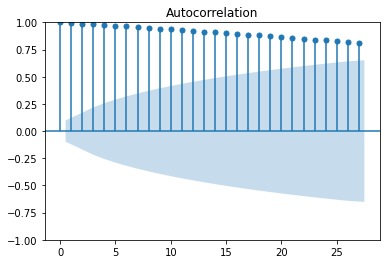

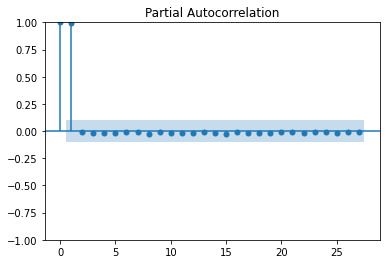

In [47]:
plot_acf(train_data[CASE_TYPE]);
plot_pacf(train_data[CASE_TYPE]);

Because this series doesn't seem to have any obvious signs of seasonality, I'm going to try the Holt-Winters (linear & exponential, non-seasonal) method to model this data, as it is a model which can be used for non-seasonal time-series data.

In [48]:
lin_forecast, exp_forecast = holt(train_data[CASE_TYPE], forecast_period=PRED_WINDOW);

c:\Users\lukea\miniconda3\envs\test-stats\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\lukea\miniconda3\envs\test-stats\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


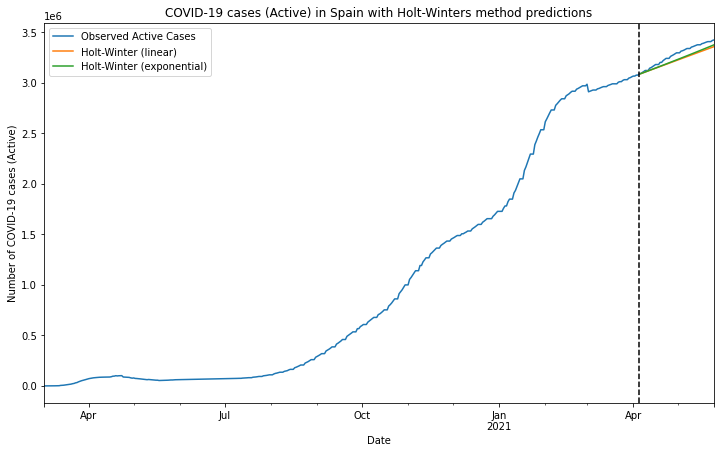

In [49]:
fig, ax = plt.subplots()

pd.concat([train_data, test_data])[CASE_TYPE].plot(ax=ax, label=f"Observed {CASE_TYPE} Cases", legend=True)
lin_forecast.plot(ax=ax, label="Holt-Winter (linear)", legend=True)
exp_forecast.plot(ax=ax, label="Holt-Winter (exponential)", legend=True)
ax.axvline(x=train_data.index[TRAIN_SIZE-1], color='k', linestyle='--')

ax.set_title(f"COVID-19 cases ({CASE_TYPE}) in {COUNTRY} with Holt-Winters method predictions")
ax.set_ylabel(f"Number of COVID-19 cases ({CASE_TYPE})")
fig.figure.set_figheight(7)
fig.figure.set_figwidth(12)

In [50]:
# linear model evaluation

evaluate_model(test_data[CASE_TYPE], lin_forecast)

,metric,score
0,rmse,59758.892853
1,mape,1.650254


In [51]:
# exponential model evaluation

evaluate_model(test_data[CASE_TYPE], exp_forecast)

,metric,score
0,rmse,52011.374823
1,mape,1.444523


This is where I'll stop for now...